In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


In [8]:
ticker = 'RELIANCE.NS'  # Reliance Industries
indian_tickers = ['RELIANCE.NS', 'INFY.NS', 'TCS.NS', 'HDFCBANK.NS']
start_date = '2023-01-01'
end_date = '2025-01-01'

In [9]:
def get_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    if data.empty:
        raise ValueError("No data found for the given ticker and date range.")
    return data

In [10]:
stock_data = get_stock_data(ticker, start_date, end_date).ffill().bfill()

[*********************100%***********************]  1 of 1 completed


In [11]:
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200, min_periods=1).mean()
stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
stock_data['Volatility'] = stock_data['Close'].pct_change().rolling(window=30, min_periods=1).std()
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
stock_data['Cumulative_Return'] = (1 + stock_data['Daily_Return']).cumprod()

In [12]:
df_corr = pd.DataFrame()
for t in indian_tickers:
    df_corr[t] = yf.download(t, start=start_date, end=end_date)['Close']
df_corr.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


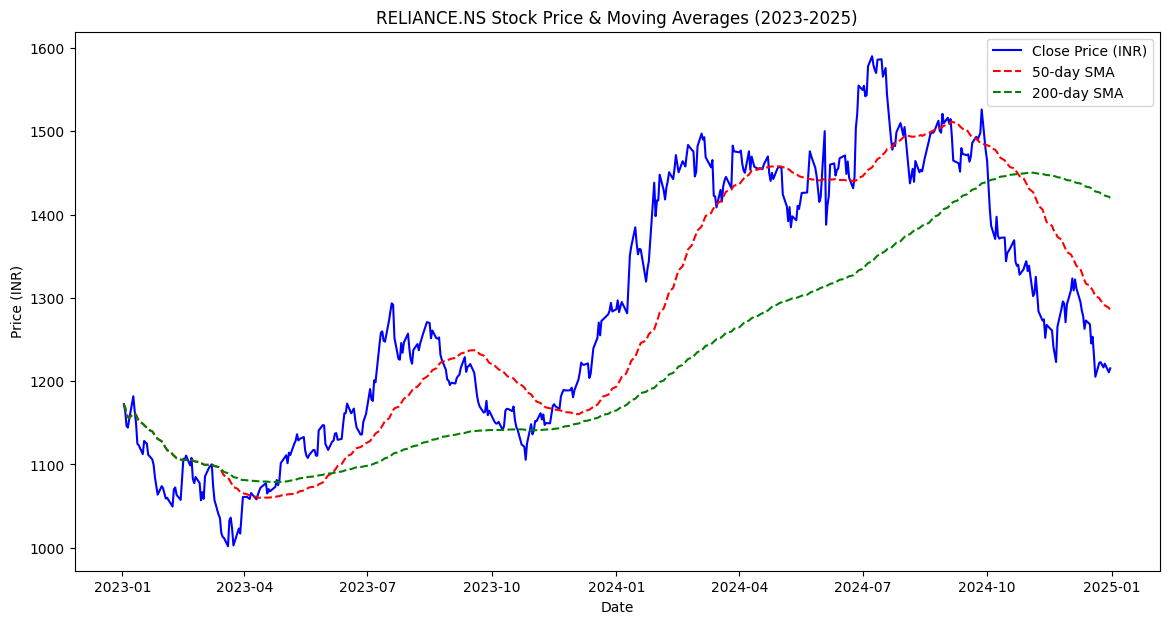

In [13]:
plt.figure(figsize=(14,7))
plt.plot(stock_data.index, stock_data['Close'], label="Close Price (INR)", color='blue')
plt.plot(stock_data.index, stock_data['SMA_50'], label="50-day SMA", color='red', linestyle='dashed')
plt.plot(stock_data.index, stock_data['SMA_200'], label="200-day SMA", color='green', linestyle='dashed')
plt.title(f'{ticker} Stock Price & Moving Averages (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

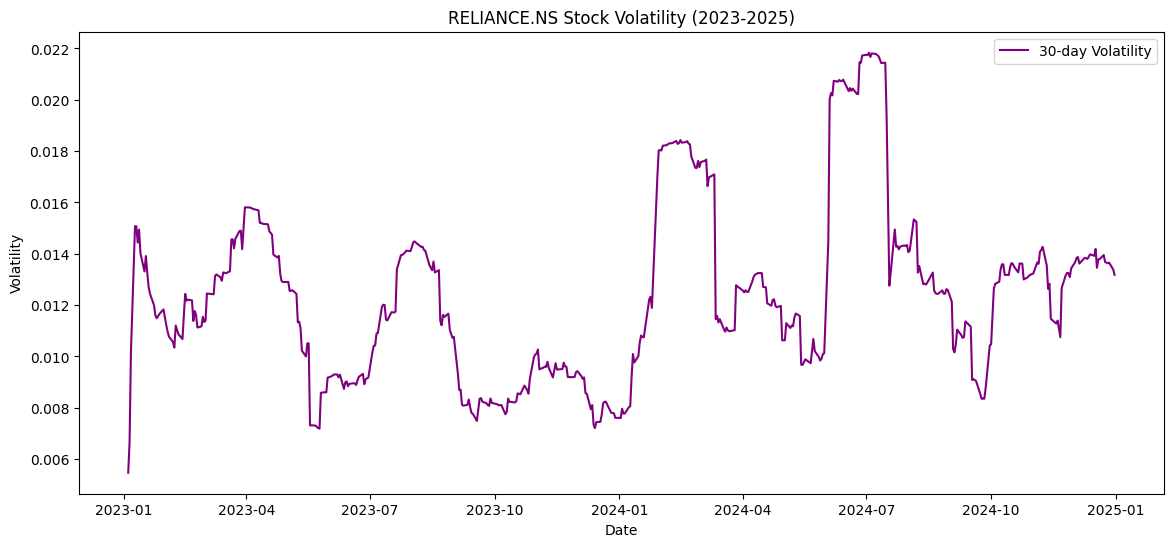

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(stock_data.index, stock_data['Volatility'], label='30-day Volatility', color='purple')
plt.title(f'{ticker} Stock Volatility (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


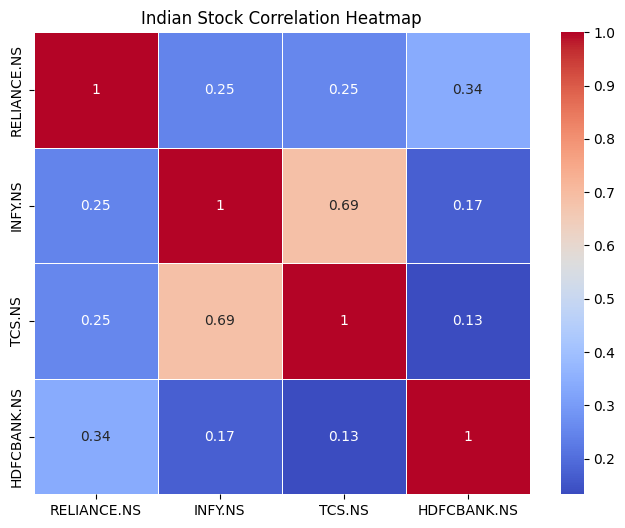

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df_corr.pct_change().corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Indian Stock Correlation Heatmap")
plt.show()

In [ ]:
filtered_stock_data = stock_data.dropna(subset=[])
fig = go.Figure(data=[go.Candlestick(
    x=filtered_stock_data.index,
    open=filtered_stock_data['Open'],
    high=filtered_stock_data['High'],
    low=filtered_stock_data['Low'],
    close=filtered_stock_data['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])
fig.update_layout(
    title=f"{ticker} Candlestick Chart (INR)",
    xaxis_title="Date",
    yaxis_title="Price (INR)",
    xaxis_rangeslider_visible=False
)
fig.show()

In [ ]:
df = stock_data[['Close']].dropna()
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)


In [ ]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

sequence_length = 50
X, y = create_sequences(df_scaled, sequence_length)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.1220 - val_loss: 0.0390
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0159 - val_loss: 0.0076
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0062 - val_loss: 0.0087
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 

In [ ]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


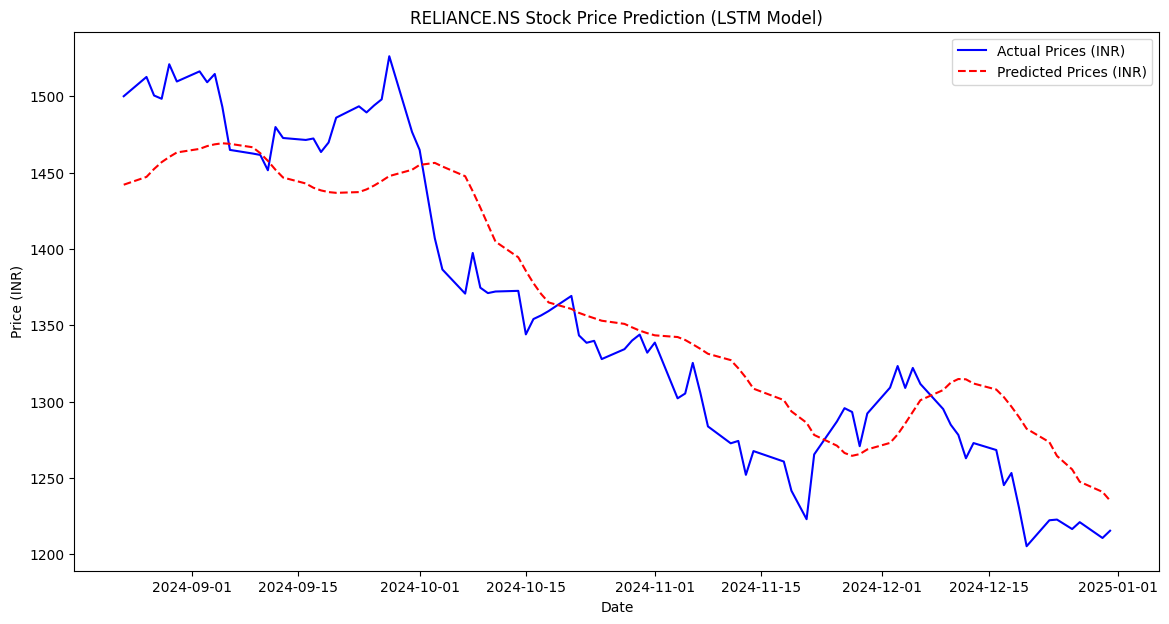

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(stock_data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual Prices (INR)", color='blue')
plt.plot(stock_data.index[-len(predicted_prices):], predicted_prices, label="Predicted Prices (INR)", color='red', linestyle='dashed')
plt.title(f'{ticker} Stock Price Prediction (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()